##Importing the required libraries

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize

###Defining the convolutional block

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x) 
    x = Activation("relu")(x)

    return x

###Defining the downsampling block

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   


###Defining the upsampling block

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) 

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="U-Net")
    return model

##Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 42
np.random.seed = seed

##Importing the dataset

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/MyDrive/U-Net/train/'
TEST_PATH = '/content/drive/MyDrive/U-Net/test/'

In [ ]:
x = next(os.walk(TRAIN_PATH))
images,masks = x[1]
print(next(os.walk(os.path.join(x[0], images)))[2])

y = next(os.walk(TEST_PATH))
images2,masks2 = y[1]
print(next(os.walk(os.path.join(y[0], images2)))[2])

['dr_23_2843.jpg', 'dr_0_728.jpg', 'WhatsApp Image 2021-12-19 at 12.20.01.jpeg', 'dr_7_6616.jpg', 'dr_0_1317.jpg', 'dr_10_1901.jpg', 'WhatsApp Image 2021-12-19 at 12.20.08 (1).jpeg', 'dr_10_2344.jpg', 'WhatsApp Image 2021-12-20 at 17.57.24 (1).jpeg', 'dr_11_8925.jpg', 'dr_19_3059.jpg', 'WhatsApp Image 2021-12-19 at 12.20.05 (1).jpeg', 'WhatsApp Image 2021-12-19 at 12.08.50.jpeg', 'WhatsApp Image 2021-12-19 at 12.08.50 (1).jpeg', 'dr_7_2528.jpg', 'WhatsApp Image 2021-12-20 at 17.58.25 (1).jpeg', 'dr_0_613.jpg', 'WhatsApp Image 2021-12-20 at 17.57.21.jpeg', 'dr_17_4517.jpg', 'WhatsApp Image 2021-12-20 at 17.57.21 (1).jpeg', 'WhatsApp Image 2021-12-19 at 12.19.58 (1).jpeg', 'dr_10_1018.jpg', 'dr_43_4064.jpg', 'dr_6_158.jpg', 'dr_18_4661.jpg', 'dr_42_8135.jpg', 'dr_7_3052.jpg', 'dr_19_8697.jpg', 'WhatsApp Image 2021-12-20 at 17.58.24.jpeg', 'dr_2_1681.jpg', 'dr_6_1024.jpg', 'WhatsApp Image 2021-12-19 at 12.08.43 (1).jpeg', 'WhatsApp Image 2021-12-19 at 12.08.43.jpeg', 'WhatsApp Image 2021-

In [ ]:
train_ids = next(os.walk(os.path.join(x[0], images)))[2]
test_ids = next(os.walk(os.path.join(y[0], y[1][0])))[2]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
print(X_train.shape, Y_train.shape)

(74, 256, 256, 3) (74, 256, 256, 1)


##Creating train and test datasets for model training

In [ ]:
n = 0
for im in train_ids:
  img = imread(TRAIN_PATH + '/images/' + im)[:,:,:IMG_CHANNELS]  
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True)
  X_train[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  mask_ = imread(TRAIN_PATH + '/masks/' + im)
  mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True), axis=-1)
  mask = np.maximum(mask, mask_)
  Y_train[n] = mask
  n += 1

In [ ]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = []
k = 0
for im in test_ids:
  img = imread(TEST_PATH + '/images/' + im)[:,:,:IMG_CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True)
  X_test[k] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  mask_ = imread(TEST_PATH + '/masks/' + im)
  mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True), axis=-1)
  mask = np.maximum(mask, mask_)
  Y_test[k] = mask
  k += 1



##Augmentation of the dataset

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)

In [ ]:
batch_size= 16
seed = 42
image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) 

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow(Y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(Y_test, seed=seed, batch_size=batch_size)  

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [ ]:
steps_per_epoch = 3*(len(X_train))//batch_size

##Example of image from the dataset

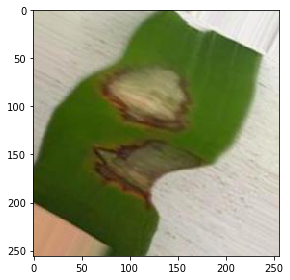

In [ ]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()

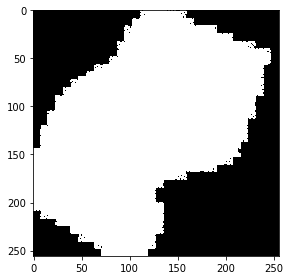

In [ ]:
imshow(np.squeeze(Y_train[image_x]))
plt.show()

Defining dice_coefficient metric function

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

from tensorflow.keras.losses import binary_crossentropy

# def loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())


##Training the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
input_shape = (256, 256, 3)
checkpointer = ModelCheckpoint('model_for_paddy.h5', verbose=1, save_best_only=True)

model = build_unet(input_shape)
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=[dice_coefficient])

with tf.device('/GPU:0'):
  results = model.fit_generator(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=250, callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/250
13/13 [==============================] - ETA: 0s - loss: 0.8580 - dice_coefficient: 0.3666
Epoch 00001: val_loss improved from inf to 1.18225, saving model to model_for_paddy.h5
13/13 [==============================] - 70s 4s/step - loss: 0.8580 - dice_coefficient: 0.3666 - val_loss: 1.1822 - val_dice_coefficient: 0.3721
Epoch 2/250
13/13 [==============================] - ETA: 0s - loss: 0.6203 - dice_coefficient: 0.3980
Epoch 00002: val_loss improved from 1.18225 to 0.73483, saving model to model_for_paddy.h5
13/13 [==============================] - 25s 2s/step - loss: 0.6203 - dice_coefficient: 0.3980 - val_loss: 0.7348 - val_dice_coefficient: 0.3593
Epoch 3/250
13/13 [==============================] - ETA: 0s - loss: 0.5260 - dice_coefficient: 0.4008
Epoch 00003: val_loss did not improve from 0.73483
13/13 [==============================] - 25s 2s/step - loss: 0.5260 - dice_coefficient: 0.4008 - val_loss: 0.7433 - val_dice_coefficient: 0.3488
Epoch 4/250
13/13 [========

##Saving the model

In [ ]:
model.save('/content/drive/MyDrive/U-Net/good_seg.h5')

##Training and validation plots

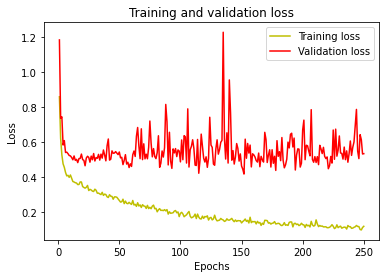

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

IoU Score

In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.5160595762658474


##Example of model prediction

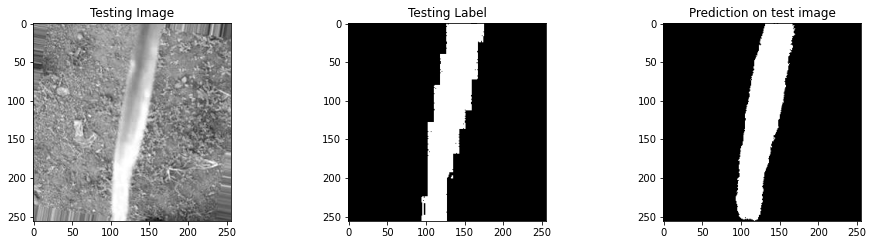

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (np.squeeze(model.predict(test_img_input) > 0.5)).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image


class TensorflowLiteClassificationModel:
    def __init__(self, model_path, labels, image_size=224):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self._input_details = self.interpreter.get_input_details()
        self._output_details = self.interpreter.get_output_details()
        self.labels = labels
        self.image_size=image_size

    def run_from_filepath(self, image_path):
        input_data_type = self._input_details[0]["dtype"]
        image = np.array(Image.open(image_path).resize((self.image_size, self.image_size)), dtype=input_data_type)
        
        if input_data_type == np.float32:
            image = image / 255.

        if image.shape == (1, 224, 224):
            image = np.stack(image*3, axis=0)

        return self.run(image)

    def run(self, image):
        image = np.expand_dims(image, axis=0)

        self.interpreter.set_tensor(self._input_details[0]["index"], image)
        self.interpreter.invoke()
        tflite_interpreter_output = self.interpreter.get_tensor(self._output_details[0]["index"])
        probabilities = np.array(tflite_interpreter_output[0])
        return probabilities

In [ ]:
labels = ["Healthy", "Leaf_Blast", "Neck_Blast", "False_Smut", "Leaf_Scald"]
model = TensorflowLiteClassificationModel("/content/model_unquant.tflite", labels=labels)
x= model.run_from_filepath("/content/dr_7_6616.jpg")
print(x)
print(labels[np.argmax(x)])

[1.4876663e-02 5.2300645e-03 2.8673330e-04 2.8245270e-04 9.7932410e-01]
Leaf_Scald
